# 기본 필요 라이브러리

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
import os
from glob import glob
import io
import numpy as np
from io import BytesIO
from tensorflow import keras

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# pd.set_option('display.max.colwidth',100)
# pd.options.display.max_columns = 100

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [77]:
os.getcwd()

'/content'

### 데이터 불러오기

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
df = pd.read_csv("/content/drive/My Drive/youtube_project/real_train.csv", encoding='utf-8-sig')
df.shape

(11199, 4)

In [80]:
df.head()

,Unnamed: 0,video_name,thumbnail,category_id
0,3801,100평인데 50평밖에 쓸 수 없는 땅 판별법,https://i.ytimg.com/vi/tBckTO0QzQo/hqdefault.j...,1
1,21501,실화!? 김메주네 집에 초대받은 랜선집사들!,https://i.ytimg.com/vi/6F18gZd0gio/hqdefault.j...,4
2,20787,물에빠지더니 극소심해진 삼색이,https://i.ytimg.com/vi/eOb17B2xyc4/hqdefault.j...,4
3,11241,듣기 싫은 꼰대어 월드컵,https://i.ytimg.com/vi/ipHmQUOgKeA/hqdefault.j...,2
4,31868,VLOG::여름대비 몸만들기::토끼와 거북이 이야기가 주는 교훈::멈추지 않는것이 ...,https://i.ytimg.com/vi/r_3wfUlmt2A/hqdefault.j...,6


In [0]:
X = df['thumbnail']
y = df['category_id']
y = np.array(y)

In [82]:
df['category_id']

0        1
1        4
2        4
3        2
4        6
        ..
11194    2
11195    3
11196    5
11197    0
11198    6
Name: category_id, Length: 11199, dtype: int64

In [83]:
df.iloc[1335:1338,]

,Unnamed: 0,video_name,thumbnail,category_id
1335,9252,[슈카월드 -5회] (2) 아니 어떻게 하면 돈을 잃을 수 있는거지?,https://i.ytimg.com/vi/yrZvNYxPNHM/hqdefault.j...,1
1336,31890,VLOG41::잘먹으며 다이어트하자 :: 운동&일상 :: 스쿼트할때 흔히 실수하는 ...,https://i.ytimg.com/vi/r39m6YmU9_w/hqdefault.j...,6
1337,7068,강남은 원래 영등포였다? (f.김시덕) [투자는 책과함께 #51-1],https://i.ytimg.com/vi/7SvoUBvA7tA/hqdefault.j...,1


In [84]:
len(X)

11199

In [85]:
df.category_id

0        1
1        4
2        4
3        2
4        6
        ..
11194    2
11195    3
11196    5
11197    0
11198    6
Name: category_id, Length: 11199, dtype: int64

In [86]:
len(X_img)

1336

# Train image features extraction

- url -> 이미지로 변환

In [0]:
from keras.preprocessing import image

In [0]:
X_img = []
for i in X :
    url = i
    response = requests.get(url) 
    img = Image.open(io.BytesIO(response.content)) 
    size = (168,94)

    img = img.resize(size)
    # img = img.convert("RGB")
    img = image.img_to_array(img)
    
    X_img.append(img)
X_img = np.array(X_img)

In [89]:
X_img.shape, y.shape

((11199, 94, 168, 3), (11199,))

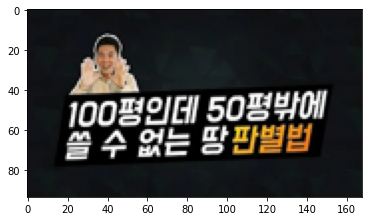

In [90]:
plt.imshow(X_img[0]/255)
# X_img.shape

# hpercent = (baseheight / float(img.size[1]))
# wsize = int((float(img.size[0]) * float(hpercent)))
# img = img.resize((wsize, baseheight), PIL.Image.ANTIALIAS)

## Transfer learning

In [91]:
# 그냥 validation_spilt 옵션 주자
# X_train = X_img
# y_train = y
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_img, y)
X_train.shape, X_valid.shape
y_train.shape

(8399,)

In [98]:
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(94, 168, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 94, 168, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 94, 168, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 94, 168, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 47, 84, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 47, 84, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 47, 84, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 23, 42, 128)       0     

### 단순예측

In [99]:
additional_model = keras.models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(keras.layers.Flatten()) # 5120
additional_model.add(keras.layers.Dense(2048, activation='relu'))
additional_model.add(keras.layers.Dense(512, activation='relu'))
additional_model.add(keras.layers.Dense(7, activation='softmax'))
 
additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              10487808  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 3591      
Total params: 26,255,175
Trainable params: 11,540,487
Non-trainable params: 14,714,688
_________________________________________________________________


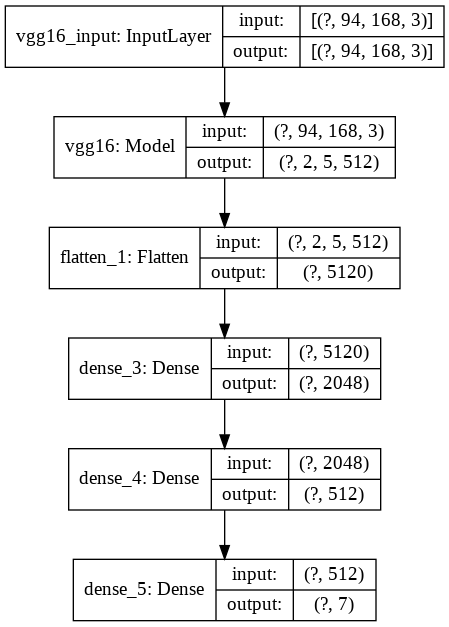

In [100]:
# additional_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
# history = additional_model.fit(X_train, y_train, epochs=10, validation_split=0.3)

# # score = additional_model.evaluate(X_test, y_test)

# # X_new = X_test[:10] # pretend we have new images
# # y_pred = additional_model.predict(X_new)
keras.utils.plot_model(additional_model, show_shapes=True)

In [101]:
additional_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = additional_model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
263/263 [==============================] - 11s 41ms/step - loss: 3.4530 - accuracy: 0.6220 - val_loss: 0.9332 - val_accuracy: 0.6936
Epoch 2/15
263/263 [==============================] - 11s 41ms/step - loss: 0.5165 - accuracy: 0.8255 - val_loss: 0.9736 - val_accuracy: 0.7043
Epoch 3/15
263/263 [==============================] - 11s 41ms/step - loss: 0.2493 - accuracy: 0.9190 - val_loss: 1.2485 - val_accuracy: 0.7046
Epoch 4/15
263/263 [==============================] - 11s 41ms/step - loss: 0.1523 - accuracy: 0.9529 - val_loss: 1.3455 - val_accuracy: 0.7061
Epoch 5/15
263/263 [==============================] - 11s 41ms/step - loss: 0.1312 - accuracy: 0.9588 - val_loss: 1.6101 - val_accuracy: 0.7011
Epoch 6/15
263/263 [==============================] - 11s 41ms/step - loss: 0.2270 - accuracy: 0.9359 - val_loss: 1.9972 - val_accuracy: 0.6825
Epoch 7/15
263/263 [==============================] - 11s 41ms/step - loss: 0.1708 - accuracy: 0.9474 - val_loss: 1.6039 - val_accuracy:

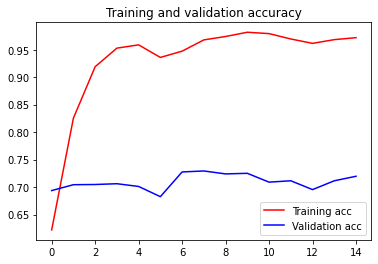

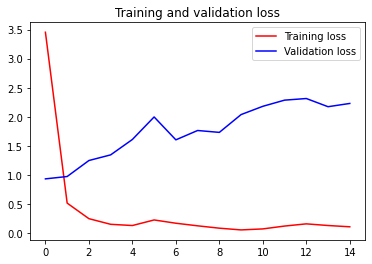

In [102]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 특성추출

In [0]:
extract_features_model = keras.models.Sequential()
extract_features_model.add(pre_trained_vgg)
extract_features_model.add(keras.layers.Flatten()) # 5120

In [0]:
extract_features_transfer_train = extract_features_model.predict(X_img)

In [105]:
extract_features_transfer_train.shape

(11199, 5120)

In [0]:
np.save("/content/drive/My Drive/youtube_project/extract_features_transfer_train", extract_features_transfer_train) # extract_features_transfer_train.npy
# /content/drive/My Drive/youtube_project/small_total_train_set.csv

# Test Image feature extraction

## Test_data

In [107]:
df2 = pd.read_csv("/content/drive/My Drive/youtube_project/real_test.csv", encoding='utf-8-sig')
df2.shape

(2800, 4)

In [108]:
Xtest = df2['thumbnail']
y_test = df2['category_id']
y_test = np.array(y_test)
len(Xtest)

2800

In [0]:
X_test = []
for i in Xtest :
    url = i
    response = requests.get(url) 
    img = Image.open(io.BytesIO(response.content)) 
    size = (168,94)

    img = img.resize(size)
    # img = img.convert("RGB")
    img = image.img_to_array(img)
    
    X_test.append(img)
    
X_test = np.array(X_test)

In [110]:
X_test.shape, y_test.shape

((2800, 94, 168, 3), (2800,))

In [113]:
score = additional_model.evaluate(X_test, y_test)
score # loss & accuracy

88/88 [==============================] - 3s 30ms/step - loss: 1.9796 - accuracy: 0.7161


[1.9795998334884644, 0.7160714268684387]

In [0]:
pred_test = np.argmax(additional_model.predict(X_test), axis=-1)

In [0]:
true_test = np.array(df2["category_id"])

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [135]:
print(classification_report(true_test,pred_test))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       400
           1       0.77      0.76      0.76       400
           2       0.58      0.70      0.63       400
           3       0.67      0.59      0.63       400
           4       0.81      0.84      0.82       400
           5       0.72      0.69      0.70       400
           6       0.68      0.60      0.64       400

    accuracy                           0.72      2800
   macro avg       0.72      0.72      0.72      2800
weighted avg       0.72      0.72      0.72      2800



In [139]:
y_true = pd.Series(true_test)
y_pred = pd.Series(pred_test)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'])

Predicted,0,1,2,3,4,5,6
True,,,,,,,
0,336,5,16,7,22,7,7
1,14,302,28,16,9,18,13
2,25,20,279,19,9,20,28
3,9,15,53,238,22,33,30
4,21,3,18,13,335,3,7
5,11,28,37,16,4,276,28
6,11,17,50,44,12,27,239


In [0]:
extract_features_transfer_test = extract_features_model.predict(X_test)

In [0]:
np.save("/content/drive/My Drive/youtube_project/extract_features_transfer_test", extract_features_transfer_test) # extract_features_transfer_train.npy

In [143]:
type(y_pred)

pandas.core.series.Series

In [0]:
y_pred.to_csv("/content/drive/My Drive/youtube_project/pred_vgg.csv",header=False)

In [149]:
y_pred

0       2
1       6
2       3
3       1
4       0
       ..
2795    0
2796    5
2797    6
2798    5
2799    5
Length: 2800, dtype: int64